In [1]:
# using google drive
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/My Drive/Stock/LSTM/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Packages

In [2]:
import os
import csv
import math
import time
import matplotlib
import numpy as np
import pandas as pd
import pandas_datareader as web
from datetime import datetime
from datetime import timedelta
from datetime import date
from pylab import rc, rcParams
from tqdm import tqdm_notebook
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.utils import plot_model
from keras.models import model_from_json
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


# Parameters

In [0]:
stock = 'acn' # stock
days = 5000   # maximum number of samples
predict_var = 'adj_close'
test_size = 0.2
N=3           # using N value of x to get y 

lstm_units=128                 # lstm param
dropout_prob=0.2               # lstm param
optimizer='adam'               # lstm param
epochs=200                     # lstm param
batch_size=8                   # lstm param

pred_N = 3                     # prediction param

# Functions

In [0]:
# scaled train data
def scale_train_data(data, N):
    x_scaled, y_scaled = [], []
    for i in range(N, len(data)):
        data_x_y = data[i-N:i+1]
        data_x_y = np.array(data_x_y[predict_var]).reshape(-1,1)
        scaler = StandardScaler()
        train_scaled = scaler.fit_transform(data_x_y)
        x_scaled.append(train_scaled[0:N])
        y_scaled.append(train_scaled[N])
    
    x_train_scaled = np.array(x_scaled)
    y_train_scaled = np.array(y_scaled)
    return x_train_scaled, y_train_scaled 

# scaled test data
def scale_test_data(data, N, offset):
    x_test_scaled, y_test, mu_test, std_test = [], [], [], []
    for i in range(offset, len(data)):
        data_x_y = data[i-N:i+1]
        data_x_y = np.array(data_x_y[predict_var]).reshape(-1,1)
        mean = np.mean(data_x_y[0:N])
        std_ = np.std(data_x_y[0:N])
        x_test_scaled.append((data_x_y[0:N]-mean)/std_)
        y_test.append(data_x_y[N])
        mu_test.append(mean)
        std_test.append(std_)

    x_test_scaled = np.array(x_test_scaled)
    y_test = np.array(y_test)
    return x_test_scaled, y_test, mu_test, std_test

def get_percentage_error(y_true,y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Load Stock Data

In [0]:
# load stock history data from yahoo and save to csv file
fileName = stock.upper()
start = datetime.now() - timedelta(days=days)
end = datetime.now()
df = web.DataReader(stock, 'yahoo', start, end)
startDay = start.strftime("%Y-%m-%d")
df.to_csv(os.path.join(base_path, fileName+'.csv'))

In [6]:
# display dataframe
df = pd.read_csv(base_path+fileName+'.csv', sep = ",")
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]
df.sort_values(by='date', inplace=True, ascending=True)
df.head()

,date,high,low,open,close,volume,adj_close
0,2006-01-13,30.360001,30.070000,30.299999,30.209999,2486100.0,23.174007
1,2006-01-17,30.980000,29.500000,29.500000,30.840000,4440700.0,23.657282
2,2006-01-18,31.000000,30.410000,30.420000,30.990000,3454900.0,23.772346
3,2006-01-19,31.240000,30.799999,30.900000,31.090000,2672600.0,23.849056
4,2006-01-20,31.580000,31.100000,31.110001,31.190001,3899700.0,23.925766


In [7]:
df.tail()

,date,high,low,open,close,volume,adj_close
3440,2019-09-16,195.220001,193.009995,193.369995,194.160004,1360000.0,194.160004
3441,2019-09-17,195.789993,193.360001,193.360001,194.949997,1457800.0,194.949997
3442,2019-09-18,194.589996,191.539993,194.179993,194.130005,1780500.0,194.130005
3443,2019-09-19,196.130005,194.220001,194.479996,194.669998,1567900.0,194.669998
3444,2019-09-20,196.229996,192.449997,195.050003,193.089996,2541000.0,193.089996


Text(0, 0.5, 'USD')

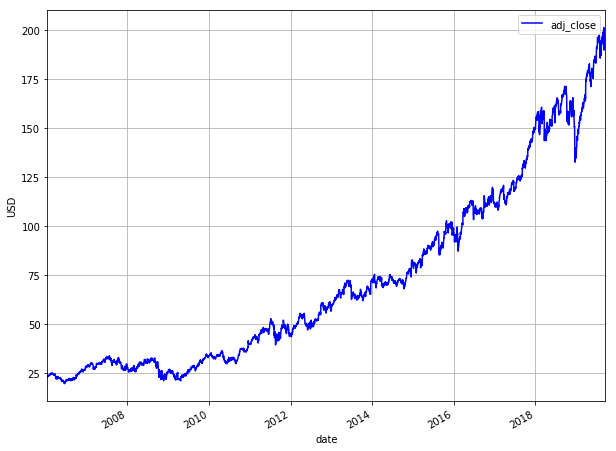

In [8]:
# plot history data
rcParams['figure.figsize'] = 10, 8 
ax = df.plot(x='date', y=predict_var, style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Modeling
This part is for modeling. If you have already train your model, you can skip to prediction.

## Split into train and test sets

In [9]:
num_test = int(test_size*len(df))
num_train = len(df) - num_test
print("Number of testing is: " + str(num_test))
print("Number of training is: " + str(num_train))

Number of testing is: 689
Number of training is: 2756


In [10]:
train = df[:num_train][['date', predict_var]]
test = df[num_train:][['date', predict_var]]
print("train.shape = " + str(train.shape))
print("test.shape = " + str(test.shape))

train.shape = (2756, 2)
test.shape = (689, 2)


## Tuning N

In [11]:
N_list = [i for i in range(3,10)]
error = {'N': [], 'rmse': [], 'percentage_error':[]}
tic = time.time()
for N in tqdm_notebook(N_list):
    x_train_scaled, y_train_scaled = scale_train_data(train, N)
    x_test_scaled, y_test, mu_test, std_test = scale_test_data(df, N, num_train)
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1],1)))
    model.add(Dropout(dropout_prob)) 
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_prob)) 
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(x_train_scaled, y_train_scaled, epochs=40, batch_size=batch_size, verbose=0)
    est_scaled = model.predict(x_test_scaled)
    est = (est_scaled * np.array(std_test).reshape(-1,1)) + np.array(mu_test).reshape(-1,1)
    rmse = math.sqrt(mean_squared_error(y_test, est))
    p_error = get_percentage_error(y_test, est)
    
    error['N'].append(N)
    error['rmse'].append(rmse)
    error['percentage_error'].append(p_error)
toc = time.time()
error = pd.DataFrame(error)
print("Minutes taken = " + str((toc-tic)/60.0))
error
    





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Minutes taken = 28.797118445237476


,N,rmse,percentage_error
0,3,2.152683,0.968083
1,4,2.346298,1.074464
2,5,2.466749,1.149329
3,6,2.687977,1.259549
4,7,2.756037,1.300653
5,8,2.885921,1.396586
6,9,3.001752,1.469939


Text(0, 0.5, 'RMSE')

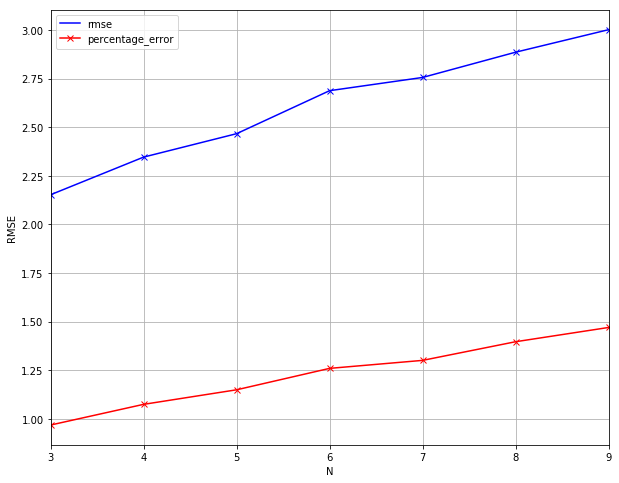

In [12]:
rcParams['figure.figsize'] = 10, 8 

ax = error.plot(x='N', y='rmse', style='bx-', grid=True)
ax = error.plot(x='N', y='percentage_error', style='rx-', grid=True, ax=ax)
ax.set_xlabel("N")
ax.set_ylabel("RMSE") 

In [0]:
temp = error[error['percentage_error'] == error['percentage_error'].min()]
N = temp['N'].values[0]

## Train Model

In [14]:
# scaled train data
x_train_scaled, y_train_scaled = scale_train_data(train, N)

print("x_train_scaled.shape = " + str(x_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))

x_train_scaled.shape = (2753, 3, 1)
y_train_scaled.shape = (2753, 1)


In [15]:
# scaled test data
x_test_scaled, y_test, mu_test, std_test = scale_test_data(df, N, num_train)

print("x_test_scaled.shape = " + str(x_test_scaled.shape))
print("y_test_scaled.shape = " + str(y_test.shape))

x_test_scaled.shape = (689, 3, 1)
y_test_scaled.shape = (689, 1)


In [16]:
model = Sequential()
model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1],1)))
model.add(Dropout(dropout_prob)) 
model.add(LSTM(units=lstm_units))
model.add(Dropout(dropout_prob)) 
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=optimizer)
model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/200
 - 9s - loss: 0.1275
Epoch 2/200
 - 5s - loss: 0.0074
Epoch 3/200
 - 4s - loss: 0.0078
Epoch 4/200
 - 5s - loss: 0.0067
Epoch 5/200
 - 5s - loss: 0.0067
Epoch 6/200
 - 5s - loss: 0.0065
Epoch 7/200
 - 4s - loss: 0.0079
Epoch 8/200
 - 5s - loss: 0.0061
Epoch 9/200
 - 5s - loss: 0.0065
Epoch 10/200
 - 4s - loss: 0.0065
Epoch 11/200
 - 5s - loss: 0.0066
Epoch 12/200
 - 5s - loss: 0.0072
Epoch 13/200
 - 4s - loss: 0.0056
Epoch 14/200
 - 4s - loss: 0.0067
Epoch 15/200
 - 4s - loss: 0.0064
Epoch 16/200
 - 4s - loss: 0.0062
Epoch 17/200
 - 5s - loss: 0.0069
Epoch 18/200
 - 4s - loss: 0.0064
Epoch 19/200
 - 4s - loss: 0.0065
Epoch 20/200
 - 4s - loss: 0.0059
Epoch 21/200
 - 4s - loss: 0.0059
Epoch 22/200
 - 5s - loss: 0.0064
Epoch 23/200
 - 4s - loss: 0.0062
Epoch 24/200
 - 4s - loss: 0.0061
Epoch 25/200
 - 4s - loss: 0.0061
Epoch 26/200
 - 4s - loss: 0.0054
Epoch 27/200
 - 5s - loss: 0.0057
Epoch 28/200
 - 5s - loss: 0.0059
Epoch 29/200
 - 5s - loss: 0.0056
Epoch 30/200
 - 5s - lo

## Testing

In [17]:
est_scaled = model.predict(x_test_scaled)
est = (est_scaled * np.array(std_test).reshape(-1,1)) + np.array(mu_test).reshape(-1,1)
rmse = math.sqrt(mean_squared_error(y_test, est))
p_error = get_percentage_error(y_test, est)
rmse,p_error

(2.2066699648469372, 0.9945883656515523)

In [18]:
result_df = pd.DataFrame({'date': df[num_train:]['date'],
                          'pred_y': est.reshape(-1),
                          'actual_y':y_test.reshape(-1)})
result_df.head(10)

,date,pred_y,actual_y
2756,2016-12-23,114.537807,112.187943
2757,2016-12-27,112.425380,112.254799
2758,2016-12-28,112.308559,111.357140
2759,2016-12-29,111.949149,111.739128
2760,2016-12-30,111.779313,111.853714
2761,2017-01-03,111.642718,111.213890
2762,2017-01-04,111.612468,111.481277
2763,2017-01-05,111.513274,109.810112
2764,2017-01-06,110.862370,111.061104
2765,2017-01-09,110.765306,109.819664


In [19]:
result_df.tail(10)

,date,pred_y,actual_y
3435,2019-09-09,199.377062,194.830002
3436,2019-09-10,198.572977,189.660004
3437,2019-09-11,195.285942,191.369995
3438,2019-09-12,191.937850,195.520004
3439,2019-09-13,192.054558,194.619995
3440,2019-09-16,193.790566,194.160004
3441,2019-09-17,194.773665,194.949997
3442,2019-09-18,194.560384,194.130005
3443,2019-09-19,194.414685,194.669998
3444,2019-09-20,194.575489,193.089996


Text(0, 0.5, 'USD')

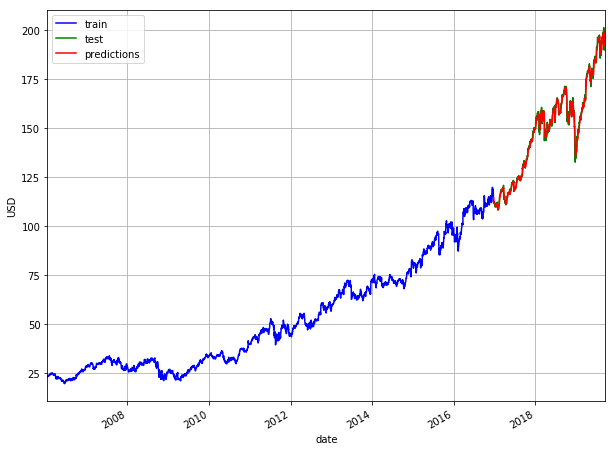

In [20]:
rcParams['figure.figsize'] = 10, 8

est_df = pd.DataFrame({'est': est.reshape(-1), 
                       'date': df[num_train:]['date']})

ax = train.plot(x='date', y=predict_var, style='b-', grid=True)
ax = test.plot(x='date', y=predict_var, style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to test set')

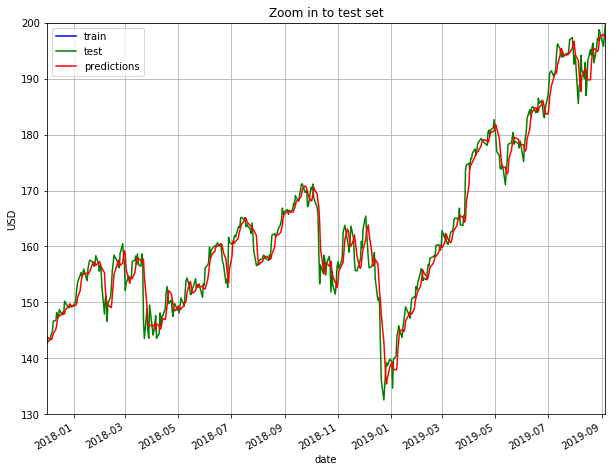

In [21]:
rcParams['figure.figsize'] = 10, 8 
ax = train.plot(x='date', y=predict_var, style='b-', grid=True)
ax = test.plot(x='date', y=predict_var, style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train',  'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2017, 12, 1), date(2019, 9, 5)])
ax.set_ylim([130, 200])
ax.set_title("Zoom in to test set")

## Save Model

In [0]:
model_json = model.to_json()
with open(base_path+"model/"+fileName+"_model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights(base_path+"model/"+fileName+"_model.h5")

# Prediction

## Load Model

In [0]:
json_file = open(base_path+"model/"+fileName+"_model.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights(base_path+"model/"+fileName+"_model.h5")

## Predict stock price

In [24]:
df_pred = df[predict_var]
prediction = []
for i in range(pred_N):
    df_pred = df_pred[-N:]
    pred = np.array(df_pred).reshape(-1,1)
    mean = np.mean(pred[0:N])
    std = np.std(pred[0:N])
    x_pred_scaled = []
    x_pred_scaled.append((pred[0:N]-mean)/std)
    x_pred_scaled = np.array(x_pred_scaled)
    est_scaled = model.predict(x_pred_scaled)
    est = est_scaled.item(0) * std + mean
    pred_row = pd.Series([est])
    df_pred = df_pred.append(pred_row , ignore_index=True)
    prediction.append(est)

print("Future "+str(pred_N)+" days prediction: ")
prediction
    

Future 3 days prediction: 


[193.98527060712823, 193.90282848168548, 193.6483300217856]